<a name = 'top'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<center><img src = 'http://www.evanmarie.com/content/files/notebook_images/ethereum_banner.png' width = 900></center>

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from helpers import *
import tqdm as tq

In [51]:
pl.seed_everything(123)
import yfinance as yf
tq.tqdm.pandas()

INFO:lightning_fabric.utilities.seed:Global seed set to 123


<a name = 'compile_stocks'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---
<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**compile_stocks()**
* Yahoo Finance only allows 7 days worth of data at 1 minute intervals
* This function will compile dataframes in 7 day increments for an entire range of dates
* They also only allow 1 min data for up to 30 days prior
* This can be used for other intervals that allow for longer time periods

In [ ]:
def compile_stocks(symbol, end, start, day_window, interval):
	import datetime
	import yfinance as yf
	
	end_date = end
	start_date = (pd.to_datetime(end) - datetime.timedelta(days = day_window))
	
	dfs = []
	stop_me = False
	
	while pd.to_datetime(start_date) >= pd.to_datetime(start):
		df = yf.download(symbol, 
						 start = start_date,
						 end = end_date, 
						 interval = interval)

		dfs.append(df)
		end_date = start_date
		start_date = start_date - datetime.timedelta(days = day_window)

		if start_date < pd.to_datetime(start):
			start_date = pd.to_datetime(start)
		else:
			start_date = start_date

		if start_date == end_date:
			break
		
	master_df = pd.concat(dfs).sort_values(by="Datetime")
		
	return master_df

In [ ]:
data = compile_stocks('ETH-USD', 
					 '2023-01-24', 
					 '2022-12-27',
					 7, '1m')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<a name = 'the_data'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**The Data**

In [ ]:
df = data[['Close', 'Volume']].copy()
df.columns = [x.lower() for x in df.columns]
head_tail_horz(df, 3, 'Raw Ethereum Data', intraday=True)

,close,volume
Datetime,,
2022-12-27 00:00:00+00:00,"1,226.99",0
2022-12-27 00:01:00+00:00,"1,227.44",0
2022-12-27 00:02:00+00:00,"1,228.57","14,410,752"
,close,volume
Datetime,,
2023-01-23 23:56:00+00:00,"1,629.03","323,584"
2023-01-23 23:57:00+00:00,"1,628.99","716,288"
2023-01-23 23:58:00+00:00,"1,628.44",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40100 entries, 2022-12-27 00:00:00+00:00 to 2023-01-23 23:58:00+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   40100 non-null  float64
 1   volume  40100 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 939.8 KB


In [ ]:
df.shape

(40100, 2)

<a name = 'change_column'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

## **`add_change_column()`**

<font size = 3><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Shift Method**
* using `shift()` to add the previous timestamp value
* then creating a difference column to show change since last
* `add_change_column()` is the function that will do all this

In [ ]:
def add_change_column(df, column_changing, new_col_name):
	df['previous'] = df[column_changing].shift()
	df = df.drop(df.index[0])
	df[new_col_name] = df[column_changing] - df.previous
	df = df.drop(columns = ['previous'])
	return df

In [ ]:
df = add_change_column(df, 'close', 'change')

In [ ]:
head_tail_vert(df, 3, "Change column added", intraday=True)

,close,volume,change
Datetime,,,
2022-12-27 00:01:00+00:00,"1,227.44",0,0.45
2022-12-27 00:02:00+00:00,"1,228.57",14410752,1.13
2022-12-27 00:03:00+00:00,"1,228.84",6625536,0.27


,close,volume,change
Datetime,,,
2023-01-23 23:56:00+00:00,"1,629.03",323584,0.14
2023-01-23 23:57:00+00:00,"1,628.99",716288,-0.03
2023-01-23 23:58:00+00:00,"1,628.44",0,-0.55


<a name = 'feature_engineering'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

## **`featurize_stocks()`** - <font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Feature Engineering**

In [ ]:
def featurize_stocks(df):
	df['weekday'] = df.index.dayofweek
	df['month_day'] = df.index.day
	df['year_week'] = df.index.isocalendar().week
	df['month'] = df.index.month
	
	return df

In [ ]:
df = featurize_stocks(df)

In [ ]:
head_tail_vert(df, 3, 'df with added features')

,close,volume,change,weekday,month_day,year_week,month
Datetime,,,,,,,
2022-12-27,"1,227.44",0,0.45,1,27,52,12
2022-12-27,"1,228.57",14410752,1.13,1,27,52,12
2022-12-27,"1,228.84",6625536,0.27,1,27,52,12


,close,volume,change,weekday,month_day,year_week,month
Datetime,,,,,,,
2023-01-23,"1,629.03",323584,0.14,0,23,4,1
2023-01-23,"1,628.99",716288,-0.03,0,23,4,1
2023-01-23,"1,628.44",0,-0.55,0,23,4,1


In [ ]:
describe_em(df, ['close', 'volume', 'change'])

,close
count,"40,099.00"
mean,"1,375.36"
std,164.02
min,"1,185.70"
25%,"1,217.39"
50%,"1,324.79"
75%,"1,548.57"
max,"1,674.18"
,volume
count,"40,099.00"


In [ ]:
df.shape

(40099, 7)

<a name = 'splitting'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Splitting & Scaling the Data**

In [ ]:
train_size = int(len(df) * .8)
pretty(f'number of training inputs: {train_size:,}.')
test_size = int(len(df) * .2)
pretty(f'number of testing inputs: {test_size:,}.')

In [ ]:
train_df, test_df = df[:train_size], df[train_size + 1:]

In [ ]:
pretty(f'train_df.shape: {train_df.shape}  |  test_df.shape: {test_df.shape}')

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Scaling the data**

In [ ]:
scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = scaler.fit(train_df)

In [ ]:
train_df = pd.DataFrame(scaler.transform(train_df), 
										  index = train_df.index, 
										  columns = train_df.columns)

test_df = pd.DataFrame(scaler.transform(test_df), 
										 index = test_df.index, 
										 columns = test_df.columns)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Viewing the scaled data**

In [ ]:
multi([(train_df.head(5),'train_df.head(5)'),
	   (train_df.tail(5),'train_df.tail(5)'),
	   (test_df.head(5),'test_df.head(5)'),
	   (test_df.tail(5),'test_df.tail(5)')], intraday=True)

,close,volume,change,weekday,month_day,year_week,month
Datetime,,,,,,,
2022-12-27 00:01:00+00:00,-0.80,-1.00,-0.50,-0.67,0.73,1.00,1.00
2022-12-27 00:02:00+00:00,-0.79,-0.94,-0.46,-0.67,0.73,1.00,1.00
2022-12-27 00:03:00+00:00,-0.79,-0.97,-0.50,-0.67,0.73,1.00,1.00
2022-12-27 00:04:00+00:00,-0.78,-0.88,-0.44,-0.67,0.73,1.00,1.00
2022-12-27 00:05:00+00:00,-0.78,-0.99,-0.52,-0.67,0.73,1.00,1.00
,close,volume,change,weekday,month_day,year_week,month
Datetime,,,,,,,
2023-01-18 09:16:00+00:00,0.92,-0.97,-0.50,-0.33,0.13,-0.92,-1.00
2023-01-18 09:17:00+00:00,0.92,-1.00,-0.52,-0.33,0.13,-0.92,-1.00


<a name = 'sequences'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating sequences for training the model**
	
<font size = 4>**`compile_sequences()`**<br>
* will take input data as dataframe, a target column and the length we want the sequences to be
	
	- This will iterate over all the data from the beginning up to the last possible full sequence length in the data.<br>
	- It is also possible to write this code in a more elegant way, such as with sliding windows




## **`compile_sequences()`**

In [ ]:
def compile_sequences(input_data, target_column, sequence_length):
					 
	sequences = []
	data_size = len(input_data)
	
	for item in tq.tqdm(range(data_size - sequence_length)):
	
		# end not included, therefor it will be the label
		sequence = input_data[item : item + sequence_length]
		label_position = item + sequence_length
		
		# defining the label with the value in the label index position
		label = input_data.iloc[label_position][target_column]
		sequences.append((sequence, label))
	return sequences

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**How creating sequences works**

In [ ]:
sample_data = pd.DataFrame(dict(
							feature1 = [1, 2, 3, 4, 5, 6, 7, 8],
							label = [6, 7, 8, 9, 10, 11, 12, 13]))

In [ ]:
sample_data.head(5)

,feature1,label
0,1,6
1,2,7
2,3,8
3,4,9
4,5,10


In [ ]:
sample_sequences = compile_sequences(sample_data, 'label', 3)

100%|██████████| 5/5 [00:00<00:00, 1095.58it/s]


## **`see_sequence_samples()`**

In [ ]:
def see_sequence_samples(data, feature_list, num_samples, 
						 sequence_portion=5):
	
	total_sequences = len(data)
	
	div_print(f'There are {total_sequences:,} total squences in this data.', 
			  fontsize = 4)
	counter = 1
	
	for record in range(0, num_samples):
			see(data[record][0][feature_list].head(sequence_portion), 
				f'sequence no.{record + 1}   |   target / label -> {data[record][1]}',
			   fontsize = 3)
			counter += 1

In [ ]:
see_sequence_samples(sample_sequences, ['feature1'], num_samples = 3)

,feature1
0,1
1,2
2,3


,feature1
1,2
2,3
3,4


,feature1
2,3
3,4
4,5


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating sequences from the data**

In [ ]:
sequence_length = 60

train_sequences = compile_sequences(train_df,
								   'close',
								   sequence_length)

test_sequences = compile_sequences(test_df,
								   'close',
								   sequence_length)

100%|██████████| 7959/7959 [00:03<00:00, 2364.64it/s]


In [ ]:
see_sequence_samples(train_sequences,
					['close', 'volume', 'change'],
					num_samples = 2,
					sequence_portion = 3)

,close,volume,change
Datetime,,,
2022-12-27,-0.80,-1.00,-0.50
2022-12-27,-0.79,-0.94,-0.46
2022-12-27,-0.79,-0.97,-0.50


,close,volume,change
Datetime,,,
2022-12-27,-0.79,-0.94,-0.46
2022-12-27,-0.79,-0.97,-0.50
2022-12-27,-0.78,-0.88,-0.44


In [ ]:
see_sequence_samples(test_sequences,
					['close', 'volume', 'change'],
					num_samples = 2,
					sequence_portion = 3)

,close,volume,change
Datetime,,,
2023-01-18,0.93,-0.98,-0.47
2023-01-18,0.93,-1.00,-0.50
2023-01-18,0.93,-1.00,-0.51


,close,volume,change
Datetime,,,
2023-01-18,0.93,-1.00,-0.50
2023-01-18,0.93,-1.00,-0.51
2023-01-18,0.93,-0.99,-0.51


<a name = 'datasets'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Sequences to PyTorch Datasets**
	
* `__init__()` - takes the sequences it will work with
* `__len__()` - returns the number of sequences in any given example
* `__getitem__()` - takes the index of the item we are interested in
	* within each sequence item is a tuple with the input data as the first tuple value and the target data or label as the second
	* sequences are converted from pandas to numpy to Tensor
	* labels are converted into floats, since we are doing regression and wanting to predict floating point numbers 

In [ ]:
class TickerDataset(Dataset):
	def __init__(self, sequences):
		self.sequences = sequences
		
	def __len__(self):
		return len(self.sequences)
	
	def __getitem__(self, idx):
		sequence, label = self.sequences[idx]
		return dict(sequence = torch.Tensor(sequence.to_numpy()),
					label = torch.tensor(label).float())

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Wrapping data with PyTorch Lightning**
	
* `setup()` converts sequences into the dataset class defined above
* `train_dataloader()`, `validation_dataloader()`, `test_dataloader()`
	* create the three different kinds of dataloaders for the data
	* `train_dataloader()` -> `shuffle = False` - do not want to shuffle the data because it is timeseries data, so the order is important
		* `num_workers = 2` - speeds up training depending on GPU vs CPU 
	* `validation_dataloader()` and `test_dataloader()` - `batch_size = 1` - for testing and making predictions, we would usually do one record at a time

In [ ]:
class TickerDataModule(pl.LightningDataModule):
	
	def __init__(self, 
				 train_sequences, 
				 test_sequences, 
				 batch_size = 8):
		super().__init__()
		self.train_sequences = train_sequences
		self.test_sequences = test_sequences
		self.batch_size = batch_size
	
	def setup(self, stage = None):
		self.train_dataset = TickerDataset(self.train_sequences)
		self.test_dataset = TickerDataset(self.test_sequences)
		
	def train_dataloader(self):
		return DataLoader(self.train_dataset,
						 batch_size = self.batch_size,
						 shuffle = False,
						 num_workers = 2)
	
	def validation_dataloader(self):
		return DataLoader(self.test_dataset,
				 batch_size = 1,
				 shuffle = False,
				 num_workers = 1)
	
	def test_dataloader(self):
		return DataLoader(self.test_dataset,
				 batch_size = 1,
				 shuffle = False,
				 num_workers = 1)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Defining the data module**
* calling the module with the sequences, with `setup()`, which will create the PyTorch Datasets

In [ ]:
batch_size = 64

data_module = TickerDataModule(train_sequences, 
							   test_sequences, 
							   batch_size = batch_size)

data_module.setup(stage = None)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Investigating a single item from TickerDataset**

In [ ]:
train_dataset = TickerDataset(train_sequences)

In [ ]:
for item in train_dataset:
	print(item['sequence'].shape)
	print(item['label'].shape)
	print(item['label'])
	break

torch.Size([60, 7])
torch.Size([])
tensor(-0.8090)


<a name = 'lstm'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating the LSTM model**
* LSTM = Long short term memory neural network
	* Allows sequences with single outputs or multiple datapoints
	* Transformers can also be used for time series (as used in text and images)
	* `batch_size = True` - inputting batch size as first parameter, which is useful for using the dataloader that passes batches of sequences with 120 data points in each sequence and 9 features for each data point
	* `num_layers` - number of LSTMs stacked on one another
	* `regressor` is the final linear layer that outputs our single prediction
* `forward()`
	* `flatten_parameters()` - used for quicker distributed training with GPUs, which PyTorch lightning allows for
	* takes the features of the output of final layer of the LSTM, the hidden state and the cell state of the LSTM

In [ ]:
class PricePredictionModel(nn.Module):
	
	def __init__(self, 
				 num_features, 
				 num_hidden = 128, 
				 num_layers = 2):

		super().__init__()
		self.num_hidden = num_hidden

		self.lstm = nn.LSTM(
						input_size = num_features,
						hidden_size = num_hidden,
						batch_first = True,
						num_layers = num_layers,
						dropout = 0.2)

		self.regressor = nn.Linear(num_hidden, 1)
	
	def forward(self, inputs):
		self.lstm.flatten_parameters()
		
		# getting states from the LSTM, retrieving the last layer of hidden
		# passing the last layer to the regressor
		_, (hidden, _) = self.lstm(inputs)
		out = hidden[-1]
		return self.regressor(out)

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Creating the lightning module for the model**
* `labels.unsqueeze()` - aligns the dimensions of the output with the output of predictions from the model

In [ ]:
class TickerPricePredictor(pl.LightningModule):
	
	def __init__(self, num_features):
		super().__init__()
		
		self.model = PricePredictionModel(num_features)
		self.loss_function = nn.MSELoss()
		
	def forward(self, inputs, labels = None):
		output = self.model(inputs)
		loss = 0
		if labels is not None:
			loss = self.loss_function(output, labels.unsqueeze(dim=1))
		return loss, output
	
	def training_step(self, batch, batch_idx):
		sequences = batch['sequence']
		labels = batch['label']
		loss, outputs = self(sequences, labels)
		self.log('training loss', loss, prog_bar = True, logger = True)
		return loss
	
	def validation_step(self, batch, batch_idx):
		sequences = batch['sequence']
		labels = batch['label']
		loss, outputs = self(sequences, labels)
		self.log('validation loss', loss, prog_bar = True, logger = True)
		return loss
	
	def test_step(self, batch, batch_idx):
		sequences = batch['sequence']
		loss, outputs = self(sequences, labels)
		self.log('test loss', loss, prog_bar = True, logger = True)
		return loss
	
	def configure_optimizers(self):
		return optim.AdamW(self.parameters(), lr = 0.0001)

In [ ]:
model = TickerPricePredictor(num_features = train_df.shape[1])

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Inspecting the values within a single item in the training dataloader**<br>
<font size = 2> **NOTICE: If the following does not work, FYI it works in Google Colab. There is a PyTorch Lightning issue, even though the version is identical.**</font>

In [52]:
for item in data_module.train_dataloader():
    sequence_shape = item['sequence'].shape
    label_shape = item['label'].shape
    break

pretty(sequence_shape, "batches of sequences: 64  ->  each sequence length: 60  ->  num_features for each sequence: 7 ")
pretty(label_shape, "one label for each batch of sequences: 64")
pretty(len(data_module.train_dataloader()), "total number of batches: 501 (len(dataloader))")


<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Checkpoint Callback**<br>
* `dirpath = 'checkpoints'` - the folder where the checkpoints will be saved
* `filename = 'best_checkpoint'` - name that the best model saved during training will be saved as
* `save_top_k = 1` - how many top models to save
* `verbose = True` - how much we want to know about what is going on during training 
* `monitor = 'training loss'` - the metrics we want to monitor while training
* `mode = 'min'` - what aspect of the metric to monitor



In [ ]:
checkpoints = ModelCheckpoint(dirpath = 'checkpoints',
                                      filename = 'best_checkpoint',
                                      save_top_k = 1, 
                                      verbose = True,
                                      monitor = 'training loss',
                                      mode = 'min')


* `logger = TensorBoardLogger('lightning_logs', name = 'bitcoin_price')` - establishing the logger through TensorBoard and naming the project
* `early_stopping_callback = EarlyStopping(monitor = 'val loss')` - a second callback that watches the validation loss and if there is no improvement for 2 epochs (`patience = 2`), the training will stop

In [ ]:
early_stopping = EarlyStopping(monitor = 'training loss', patience = 3)

<a name = 'trainer'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Training the Model**



* setting up the trainer to train the model

In [ ]:
num_epochs = 10

trainer = pl.Trainer(callbacks = [checkpoints, early_stopping],
                     max_epochs = num_epochs,
                     auto_lr_find=True,
                     gpus = 1)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | PricePredictionModel | 202 K 
1 | loss_function | MSELoss              | 0     
-------------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.809     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 501: 'training loss' reached 0.00245 (best 0.00245), saving model to '/content/checkpoints/best_checkpoint-v5.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1002: 'training loss' reached 0.00207 (best 0.00207), saving model to '/content/checkpoints/best_checkpoint-v5.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1503: 'training loss' reached 0.00100 (best 0.00100), saving model to '/content/checkpoints/best_checkpoint-v5.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2004: 'training loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2505: 'training loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3006: 'training loss' was not in top 1


<a name = 'results'></a>

---

**SECTIONS: [Top](#top)  |  [Compile Stocks](#compile_stocks)  |  [The Data](#the_data)  |  [Add Change Column](#change_column)  |  [Feature Engineering](#feature_engineering)  |  [Splitting & Scaling](#splitting)  |  [Creating Sequences](#sequences)  |  [PyTorch Datasets](#datasets)  |  [LSTM](#lstm)  |  [Trainer](#trainer)  |  [Results](#results)  |**

---

<font size = 4><span style = 'background-color: #ddddff; padding: 5px 5px 3px 5px; line-height: 1.5; color:black;border-radius: 3px;'>**Loading a Pre-Trained Model & Getting Predictions**

In [ ]:
trained_model = TickerPricePredictor.load_from_checkpoint('/content/checkpoints/best_checkpoint.ckpt',
                                                         num_features = train_df.shape[1])

trained_model.freeze()

In [ ]:
test_dataset = TickerDataset(test_sequences)

<font size = 4>`get_predictions()`

In [ ]:
def get_predictions(model, 
                    test_dataset, 
                    original_df = df,
                    train_size = len(train_df),
                    sequence_length = sequence_length, 
                    scaler = scaler, 
                    plot = True):
    
    predictions = []
    labels = []
    for item in tq.tqdm(test_dataset):
        sequence = item['sequence']
        label = item['label']

        _, output = model(sequence.unsqueeze(dim=0))
        predictions.append(output.item())
        labels.append(label.item())

    test_data = df[train_size + 1 : ]
    test_sequences_data = test_data.iloc[sequence_length:]
    dates = test_sequences_data.index.tolist()

    results = pd.concat([pd.Series(dates), pd.Series(predictions), 
                         pd.Series(labels)], axis = 1)
    results.columns = ['dates', 'predictions', 'actuals']
    results = results.set_index('dates')


    def reverse_scale(scaler, data):
        reverse_scaler = MinMaxScaler()
        reverse_scaler.min_ = scaler.min_[-1]
        reverse_scaler.scale_ = scaler.scale_[-1]
        data_array = np.array(data)[:, np.newaxis]
        results = reverse_scaler.inverse_transform(data_array).flatten()
        return results


    results.predictions = reverse_scale(scaler, results.predictions)
    results.actuals = reverse_scale(scaler, results.actuals)

    results['accuracy'] = (1 - abs(results.actuals - results.predictions) / 
                       results.actuals) * 100
    
    overall_test_accuracy = results.accuracy.mean()
    
    sp(); sp();
    
    pretty(f'{overall_test_accuracy:.3f}%', 
           'The overall testing accuracy of the model is:'); sp()

    if plot == True:
        fig = plt.subplots(facecolor='#222222', figsize=(13, 7))
        ax = plt.axes();
        plt.style.use("ggplot");
        ax.set_facecolor('#333333')
        ax.grid(color=fontcolor, linestyle=':', linewidth=0.75, alpha=0.75)
        plt.tick_params(labelrotation=40);
        plt.title('Predictions vs. Actual Labels', fontsize=23, pad=20, color=fontcolor);
        plt.ylabel('Stock Prices', fontsize=18, color=fontcolor);
        plt.xlabel('Test Sequences', fontsize=18, color=fontcolor);
        plt.xticks(fontsize=10, color='white')
        plt.yticks(fontsize=10, color='white')
        results.predictions.plot(ax = ax, color = 'cyan');
        results.actuals.plot(ax = ax, color = 'deeppink');
        plt.legend(facecolor = 'DarkGray', loc = 2, fontsize=15);

    return results

100%|██████████| 7959/7959 [01:29<00:00, 88.59it/s] 

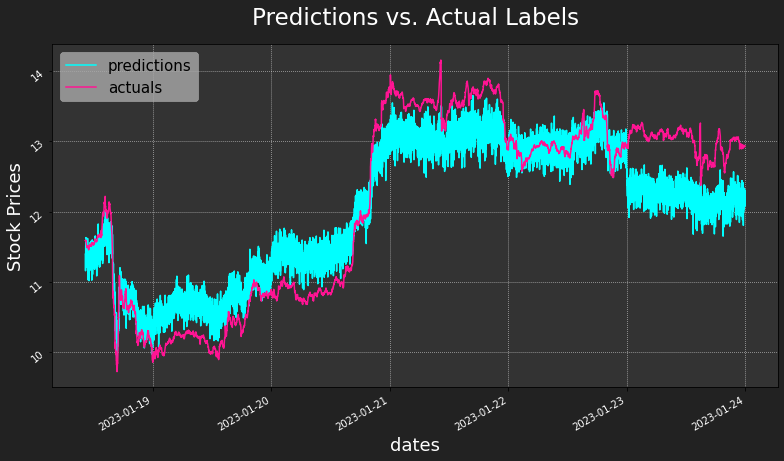

In [ ]:
results = get_predictions(model, test_dataset)